In [50]:
import pandas as pd
import numpy as np

In [51]:
bscan=pd.read_csv(r"C:\Users\HP\Desktop\Soni Chauhan\Data Science IIT-R\BreastCancer.csv")

In [52]:
#bscan.head()

In [53]:
#bscan.shape

In [54]:
#bscan.info()

In [55]:
bscan.isnull().sum()
#check for nulls/missing values

Sno.                0
Id                  0
Cl.thickness        0
Cell.size           0
Cell.shape          0
Marg.adhesion       0
Epith.c.size        0
Bare.nuclei        16
Bl.cromatin         0
Normal.nucleoli     0
Mitoses             0
Class               0
dtype: int64

In [56]:
bscan.fillna(bscan.mean(), inplace=True)
# Replacing null values with mean

In [57]:
bscan.isnull().sum()

Sno.               0
Id                 0
Cl.thickness       0
Cell.size          0
Cell.shape         0
Marg.adhesion      0
Epith.c.size       0
Bare.nuclei        0
Bl.cromatin        0
Normal.nucleoli    0
Mitoses            0
Class              0
dtype: int64

In [58]:
bscan.Class.replace({"benign" :0 , "malignant":1} ,inplace = True)
# converting categorical column into numerical

In [59]:
bscan.Class.value_counts()

0    458
1    241
Name: Class, dtype: int64

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
bscan_x=bscan.iloc[:,0:11]
bscan_y=bscan.iloc[:,11]
#separating out independent variables xi's and dependent variable y

In [62]:
bscan_x_train , bscan_x_test, bscan_y_train, bscan_y_test = train_test_split(bscan_x ,bscan_y , test_size  = .2,stratify=bscan_y)

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
rf = RandomForestClassifier(n_estimators=250,class_weight="balanced")

rf.fit(bscan_x_train  ,bscan_y_train)

pred_y  =  rf.predict(bscan_x_test)


In [64]:
bscan_y_test.value_counts()

0    92
1    48
Name: Class, dtype: int64

In [65]:
print("Accuracy:",rf.score(bscan_x_test,bscan_y_test) )
print("\nConfusion Matrix:\n", 
      pd.DataFrame(confusion_matrix(bscan_y_test,pred_y),columns=["pred:0","pred:1"],index=['true:0',"true:1"]),
      "\n\nClassification Report:\n",classification_report(bscan_y_test,pred_y))

Accuracy: 0.9571428571428572

Confusion Matrix:
         pred:0  pred:1
true:0      90       2
true:1       4      44 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        92
           1       0.96      0.92      0.94        48

    accuracy                           0.96       140
   macro avg       0.96      0.95      0.95       140
weighted avg       0.96      0.96      0.96       140



In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [67]:
rf_roc_auc= roc_auc_score(pred_y,bscan_y_test)
rf_roc_auc

0.9569842738205366

In [68]:
pred_y_prob=rf.predict_proba(bscan_x_test)
pred_y_prob=pd.DataFrame(pred_y_prob)
# the associated probabilities

In [69]:
fpr,tpr,threshold= roc_curve(bscan_y_test,pred_y_prob.iloc[:,1],)
# selecting probabilities corresp. to class 1

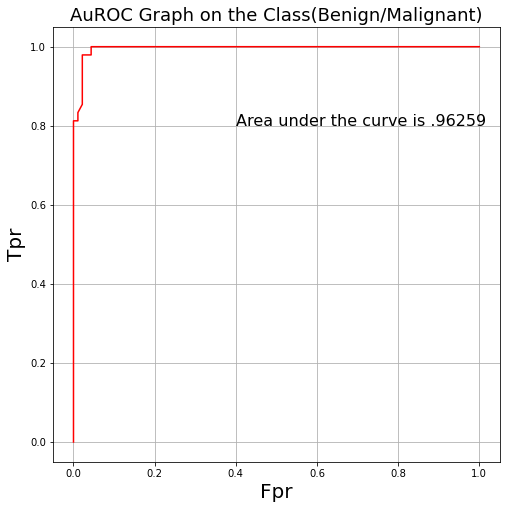

In [70]:
plt.figure(figsize=(8,8))
plt.plot(fpr,tpr,color="r")

plt.xlabel("Fpr",size=20)
plt.ylabel("Tpr",size=20)
plt.title("AuROC Graph on the Class(Benign/Malignant)",size=18)
plt.text(x=0.4,y=0.8,s="Area under the curve is .96259",size=16)
plt.grid()
plt.show()

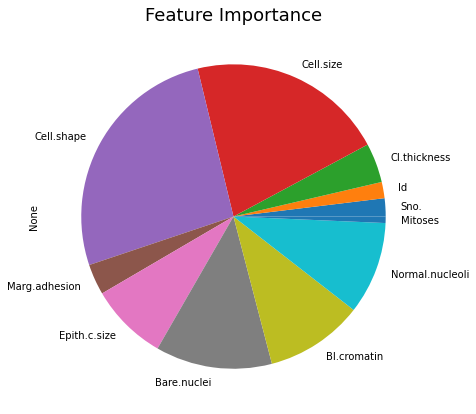

In [71]:
plt.figure(figsize=(10,7))
plt.title("Feature Importance",size=18)
feat_imortances.plot(kind='pie')


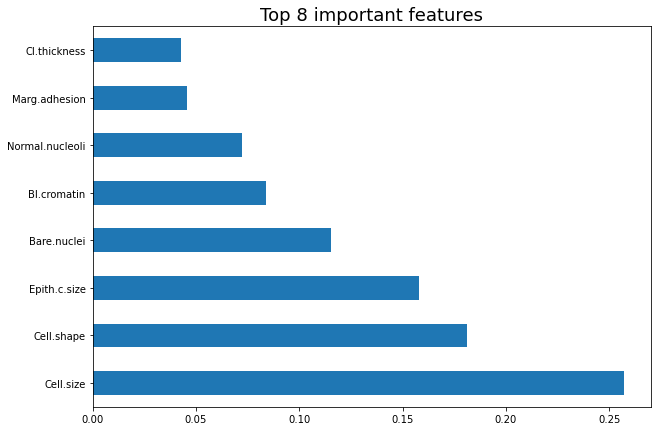

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.title("Top 8 important features",size=18)
feat_imortances=pd.Series(rf.feature_importances_,index=bscan_x_train.columns)
feat_imortances.nlargest(8).plot(kind='barh')

In [73]:
# Saving the Model
#import pickle

In [74]:
#with open("BreastCancer_rf",'wb') as f:
 #   pickle.dump(rf,f)

In [75]:
# Using top 8 important features we will build our Pipeline

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion

In [154]:
class FeatureSelector(BaseEstimator,TransformerMixin):
    def _init_(self,feature_names):
        self._feature_names=feature_names
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self._feature_names]

In [168]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def _init_(self, Class=["benign","malignant"]):
        self.Class=Class
        
    def fit(self,X,y=None):
        return self
    def create_binary(self,obj):
        if obj==0:
            return "No"
        else:
            return "yes"
    def transform(self,X,y=None):
        X.loc[:,"Class"]=X["Class"].apply(self.create_binary)
        return X.values
        
        

In [171]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def _init_(self, Mitoses):
        self.Mitoses=Mitoses
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X.values
    

In [172]:
categorical_features=["Class"]
numerical_features=["Cl.thickness","Marg.adhesion","Normal.nucleoli","Bl.cromatin","Bare.nuclei","Epith.c.size","Cell.shape","Cell.size"]


In [181]:
categorical_pipeline=Pipeline(steps=[("cat_selector",FeatureSelector()),
                                      ("cat_transformer",CategoricalTransformer()),
                                      ("one_hot_encoder", OneHotEncoder(sparse=False))])

TypeError: FeatureSelector() takes no arguments

In [175]:
numerical_pipeline=Pipeline(steps=[("num_selector",FeatureSelector(numerical_features)),
                                      ("imputer",NumericalTransformer()),
                                      ("std_scaler", StandardScaler())])

In [176]:
full_pipeline=FeatureUnion(transformer_list=[("categorical_pipeline",categorical_pipeline),
                                            ("numerical_pipeline",numerical_pipeline)])

In [177]:
X=bscan.iloc[:,0:11]
y=bscan.iloc[:,11]

In [178]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)

In [179]:
full_pipeline_m=Pipeline(steps=[("full_pipeline",full_pipeline),("model",RandomForestClassifier())])

In [180]:
full_pipeline_m.fit(X_train,y_train)

AttributeError: 'FeatureSelector' object has no attribute '_feature_names'